# Stock Market Prediction using Numerical and Textual Analysis

## The hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

### Data Source : 
### 1. historical stock prices : finance.yahoo.com
### 2. textual (news) data : https://bit.ly/36fFPI6

### Author : Pranesh Kulkarni

.

### Part 1 : Importing Libraries

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [5]:
!pip3 install statsmodels

     |████████████████████████████████| 9.5 MB 163 kB/s eta 0:00:01     |███████████████                 | 4.4 MB 168 kB/s eta 0:00:30
     |████████████████████████████████| 231 kB 156 kB/s eta 0:00:01


In [21]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import norm
import statsmodels.api as sm

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pranesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/pranesh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
! pip3 install textblob
from textblob import TextBlob

     |████████████████████████████████| 636 kB 315 kB/s eta 0:00:01


In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip3 install lightgbm
import lightgbm

     |████████████████████████████████| 1.8 MB 244 kB/s eta 0:00:01


In [20]:
!pip3 install pmdarima

     |████████████████████████████████| 1.5 MB 329 kB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 197 kB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 270 kB/s eta 0:00:01     |█████████                       | 573 kB 335 kB/s eta 0:00:05
     |████████████████████████████████| 803 kB 337 kB/s eta 0:00:01
ERROR: launchpadlib 1.10.13 requires testresources, which is not installed.
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.1
    Uninstalling statsmodels-0.12.1:
      Successfully uninstalled statsmodels-0.12.1
  Attempting uninstall: setuptools
    Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0


In [23]:
df_prices = pd.read_csv('^BSESN.csv')
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0


In [24]:
len(df_prices)

3682

In [25]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3682 non-null   datetime64[ns]
 1   Open       3655 non-null   float64       
 2   High       3655 non-null   float64       
 3   Low        3655 non-null   float64       
 4   Close      3655 non-null   float64       
 5   Adj Close  3655 non-null   float64       
 6   Volume     3655 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 201.5 KB


In [26]:
df_prices.dropna(inplace = True)
print(len(df_prices))

3655


Text(0, 0.5, 'BSESN')

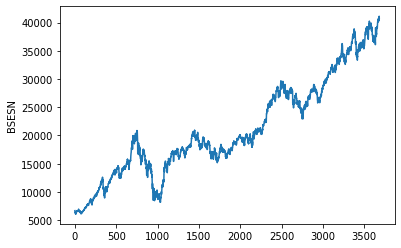

In [27]:
df_prices['Close'].plot()
plt.ylabel('BSESN')

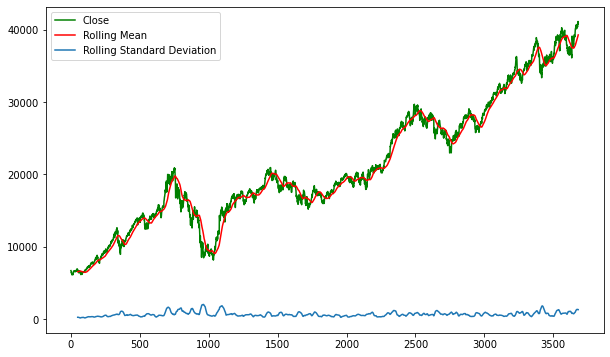

In [28]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'g', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

In [34]:
# Train test Split

train = df_prices[:3000]
test = df_prices[3000:]

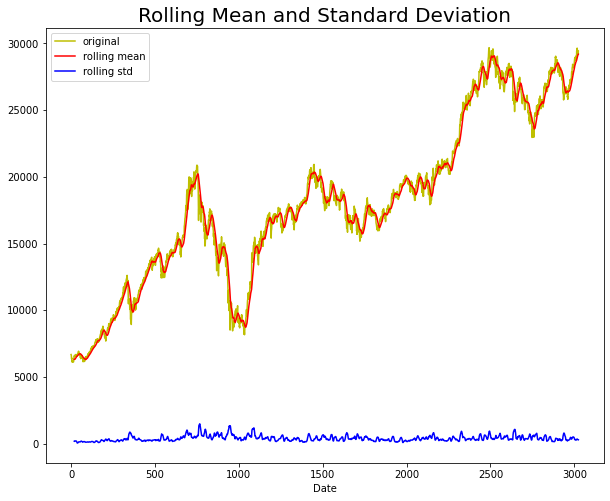

Results of dickey fuller test
ADF Test Statistic : -1.067442725521545
p-value : 0.7278792554637012
#Lags Used : 5
Number of Observations Used : 2994
Weak evidence against null hypothesis, time series is non-stationary 


In [35]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

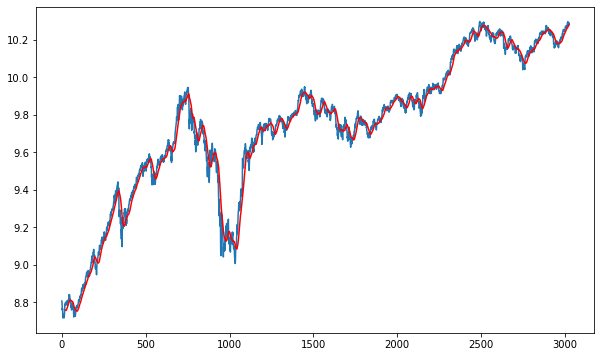

In [36]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

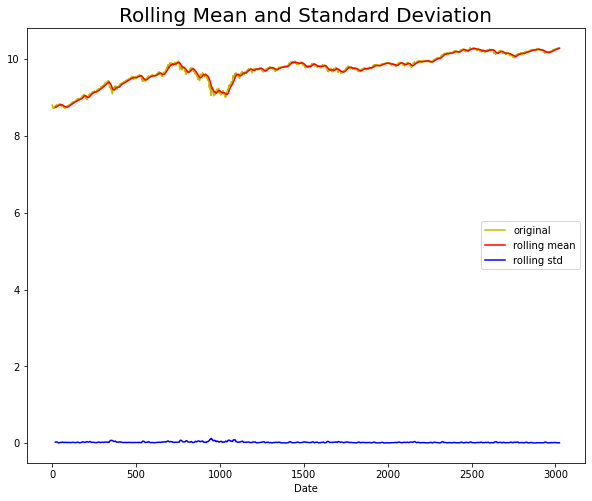

Results of dickey fuller test
ADF Test Statistic : -2.0545802810776883
p-value : 0.26316567390877976
#Lags Used : 4
Number of Observations Used : 2995
Weak evidence against null hypothesis, time series is non-stationary 


In [37]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

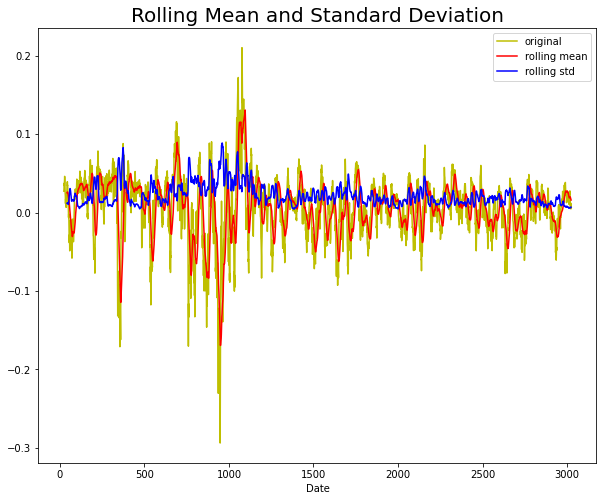

Results of dickey fuller test
ADF Test Statistic : -8.109803873988904
p-value : 1.2345888654263677e-12
#Lags Used : 22
Number of Observations Used : 2954
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [38]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

## Time series Prediction

In [43]:

#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16732.078, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16732.810, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16750.863, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16752.608, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16731.492, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16753.137, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16758.005, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16755.666, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-16753.553, Time=1.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16738.810, Time=2.76 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16755.762, Time=2.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-16747.118, Time=7.59 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16756.463, Time=0.24 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 18.575 sec

Text(0, 0.5, 'Actual Stock Price')

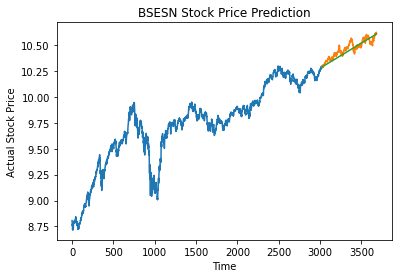

In [44]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [45]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.040734095215504515


## Textual Analysis

In [52]:
cols = ['Date','Category','News']
df_news = pd.read_csv('india-news-headlines.csv', names = cols)
df_news

/home/pranesh/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,win over cena satisfying but defeating underta...
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?
...,...,...,...
3297168,20200630,gadgets-news,why tiktok removed 1 65 crore videos in india
3297169,20200630,entertainment.hindi.bollywood,apurva asrani calls alia bhatts mother soni ra...
3297170,20200630,entertainment.hindi.bollywood,kangana ranaut gets a doll version of herself ...
3297171,20200630,entertainment.hindi.bollywood,meezaan jaffrey reminisces his childhood days ...


In [53]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 1 to 3297172
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 75.5+ MB


In [54]:
 #Converting data type of Date column 
 df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
 df_news

,Date,News
1,2001-01-01,win over cena satisfying but defeating underta...
2,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
3,2001-01-02,Fissures in Hurriyat over Pak visit
4,2001-01-02,America's unwanted heading for India?
5,2001-01-02,For bigwigs; it is destination Goa
...,...,...
3297168,2020-06-30,why tiktok removed 1 65 crore videos in india
3297169,2020-06-30,apurva asrani calls alia bhatts mother soni ra...
3297170,2020-06-30,kangana ranaut gets a doll version of herself ...
3297171,2020-06-30,meezaan jaffrey reminisces his childhood days ...


In [55]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03,Powerless north India gropes in the dark Think...
3,2001-01-04,The string that pulled Stephen Hawking to Indi...
4,2001-01-05,Light combat craft takes India into club class...
...,...,...
7075,2020-06-26,Containment zone residents slam high prices ch...
7076,2020-06-27,like me i wont let you have a toxic relationsh...
7077,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...
7078,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...


In [56]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [57]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

<ipython-input-57-8dc61a5bfe52>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
<ipython-input-57-8dc61a5bfe52>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['Polarity'] = df_news['News'].apply(getPolarity)


,Date,News,Subjectivity,Polarity
0,2001-01-01,win over cena satisfying but defeating underta...,0.633333,0.433333
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
2,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
3,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
4,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
...,...,...,...,...
7075,2020-06-26,Containment zone residents slam high prices ch...,0.381841,0.068333
7076,2020-06-27,like me i wont let you have a toxic relationsh...,0.398808,0.079290
7077,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...,0.402636,0.057636
7078,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...,0.396828,0.061956


In [58]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

<ipython-input-58-6743f3ed229d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
<ipython-input-58-6743f3ed229d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
<ipython-input-58-6743f3ed229d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01,win over cena satisfying but defeating underta...,0.633333,0.433333,-0.0000,0.230,0.473,0.297
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
2,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
3,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
4,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9769,0.124,0.719,0.157
...,...,...,...,...,...,...,...,...
7075,2020-06-26,Containment zone residents slam high prices ch...,0.381841,0.068333,-0.9999,0.163,0.748,0.089
7076,2020-06-27,like me i wont let you have a toxic relationsh...,0.398808,0.079290,-0.9999,0.159,0.749,0.092
7077,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...,0.402636,0.057636,-0.9999,0.151,0.774,0.075
7078,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...,0.396828,0.061956,-0.9999,0.144,0.770,0.086


In [59]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2005-01-03,6626.490234,6684.220215,6626.490234,6679.200195,6679.200195,12000.0,ICAI compliments minister Partnering for futur...,0.406857,0.065283,-0.9928,0.152,0.750,0.098
1,2005-01-04,6683.560059,6696.310059,6640.899902,6651.009766,6651.009766,16600.0,Arab Gaze Uniform Laws Tsunami Relief Double S...,0.369270,0.086111,-0.9149,0.085,0.847,0.069
2,2005-01-05,6628.890137,6629.979980,6337.609863,6458.839844,6458.839844,24000.0,Quake Rumours Mishap reunites 12-yr boy with f...,0.417271,0.085289,-0.9956,0.151,0.750,0.099
3,2005-01-06,6447.270020,6481.229980,6325.359863,6367.390137,6367.390137,22200.0,Doon School preparing to admit girls? Market M...,0.339338,0.175814,0.7673,0.092,0.805,0.103
4,2005-01-07,6374.189941,6440.169922,6348.750000,6420.459961,6420.459961,17800.0,Faultline Repair No Parade; Please NRI Spirit ...,0.473967,0.069047,-0.9964,0.137,0.778,0.085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3650,2019-11-25,40439.660156,40931.710938,40393.898438,40889.230469,40889.230469,28600.0,Micro review: 'The Night Fire' by Michael Conn...,0.376458,0.052672,-0.9998,0.135,0.785,0.081
3651,2019-11-26,41022.851563,41120.281250,40710.199219,40821.300781,40821.300781,32800.0,Indore's fairs and festivities will be promote...,0.391903,0.040734,-0.9999,0.160,0.760,0.081
3652,2019-11-27,40979.390625,41075.761719,40848.699219,41020.609375,41020.609375,32400.0,Kanpur: 'Tyre puncture' gang robs retired Army...,0.414482,0.044661,-0.9999,0.153,0.758,0.089
3653,2019-11-28,41161.539063,41163.789063,40996.078125,41130.171875,41130.171875,30900.0,Housing for 1;800 families: SC panel calls for...,0.398847,0.067901,-0.9998,0.116,0.818,0.066


In [63]:
exog_data = df_merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
exog_data

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.406857,0.065283,-0.9928,0.152,0.750,0.098
1,0.369270,0.086111,-0.9149,0.085,0.847,0.069
2,0.417271,0.085289,-0.9956,0.151,0.750,0.099
3,0.339338,0.175814,0.7673,0.092,0.805,0.103
4,0.473967,0.069047,-0.9964,0.137,0.778,0.085
...,...,...,...,...,...,...
3650,0.376458,0.052672,-0.9998,0.135,0.785,0.081
3651,0.391903,0.040734,-0.9999,0.160,0.760,0.081
3652,0.414482,0.044661,-0.9999,0.153,0.758,0.089
3653,0.398847,0.067901,-0.9998,0.116,0.818,0.066


In [64]:
df_time_series = df_merge['Close']

In [65]:
df_time_series

0        6679.200195
1        6651.009766
2        6458.839844
3        6367.390137
4        6420.459961
            ...     
3650    40889.230469
3651    40821.300781
3652    41020.609375
3653    41130.171875
3654    40793.808594
Name: Close, Length: 3655, dtype: float64

In [66]:
final_train_data = df_time_series[:3000]
exog_train_data = exog_data[:3000]

final_test_data = df_time_series[3000:]
exog_test_data = exog_data[3000:]

In [67]:
model = SARIMAX(final_train_data, exog=exog_train_data)#, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit()

/home/pranesh/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  from statsmodels.tools.sm_exceptions import ConvergenceWarning


Thank You